# RESPONSIBLE AI

In [1]:
import IPython


Let's get started by installing the relevant dependencies:

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
#!pip install mitdeeplearning
import mitdeeplearning as mdl

Three data sets are used, two for training and one for testing. It consists of positive examples that are the faces and  neagtive examples which are non-face images.

We then test the model on a PPB dataset, which contains images of people from both African and European countries unlike the training data set which constained a majority of images of faces of lighter skintone.

In [ ]:
# Training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
#a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

We first build a model that performs a face recognition task. Later, we compare the performance of the debiased model against a baseline CNN model

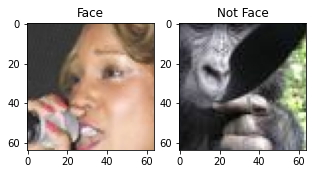

In [ ]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

## 2.2 CNN for facial detection 


We first train a baseline CNN inorder to evaluate the performance of our debiased models against this CNN.

In [ ]:
### Define the CNN model ###

n_filters = 12 


def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),    

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

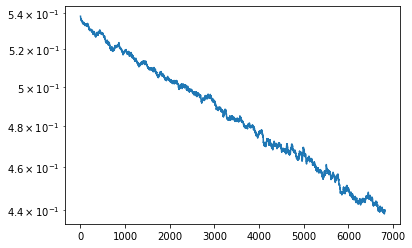

100%|██████████| 3434/3434 [00:36<00:00, 94.95it/s]


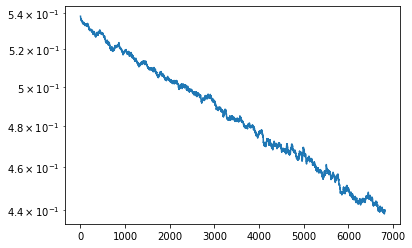

In [ ]:
### Train the standard CNN ###


batch_size = 32
num_epochs = 2  
learning_rate = 5e-8

optimizer = tf.keras.optimizers.Adam(learning_rate) 
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) 
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
   
    logits = standard_classifier(x) 
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss


for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
   
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

   
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

Evaluating the classification performance of the CNN on the training dataset.


In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA

(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9098


We also evaluate the model on an independent test dataset which contains faces that were not seen during training. For the test data, we'll look at the classification accuracy across four different demographics, based on the Fitzpatrick skin scale and sex of the individual : dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female. 



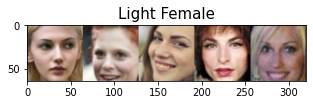

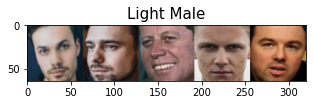

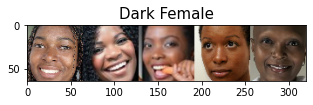

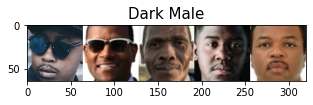

In [ ]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Even though we get an accuracy of around 90%, the probability of it accurately classifying the faces when we consider the demographics factor is lower for dark skin people than for light skin and this is when the bias of the model comes to picture

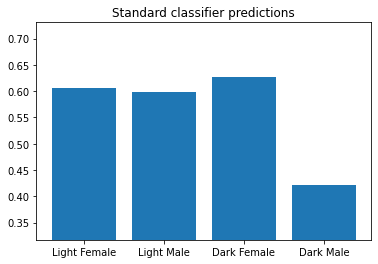

In [ ]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");



Majority of faces in the training dataset were those of light-skinned people. As a result, a classifier trained on it will do the job better at classifying them better and thus are biased.

To overcome the bias of the model, we learn the features that lead to its biasness and learn them in an unbiased, unsupervised manner and then train the image classifier according to these features.

## Variational autoencoder (VAE) for learning latent structure


Accuracy of the CNN varies across the four demographics. This arises because, the dataset that the model was trained on had a minority of certain features such as dark skin,hats or sunglasses. As a result, the model may end up biased against these. So, the classification accuracy will be lower on the faces that have these under-represented features.

We try to train a debiased version of this classifier which accounts for potential disparities in feature representation within the training data. To build a debiased facial classifier, we'll train a model that learns a representation of the underlying latent space. The model then uses this information to remove the unwanted biases by sampling faces with rare features, like dark skin or hats, more frequently during training. 

VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. The encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then decodes these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 



### Loss function

In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. These are learned parameters, and therefore contribute to the loss computation.
The decoder portion of the VAE is using these parameters to give out a reconstruction that should match the input image as close as possible, which also must factor into the loss.

So, there are two factors affecting the VAE loss function

Latent loss: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.

Reconstruction loss: measures how accurately the reconstructed outputs match the input and is given by the norm of the input image and its reconstructed output.

In [ ]:
### VAE loss function ###


def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  
  
  return vae_loss

### Reparameterization 

VAEs use reparameterization for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. 

This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!


In [ ]:
### VAE Reparameterization ###


def sampling(z_mean, z_logsigma):
  
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

  return z

## Debiasing variational autoencoder (DB-VAE)

Now, we'll use the general idea behind the VAE architecture to build a model, a debiasing variational autoencoder or DB-VAE, to remove potentially unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.    

### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data). 



### DB-VAE loss function

The form of the loss will depend on whether it's a face image or a non-face image being considered. 

For face images, the loss function will have two components:

1. VAE loss : consists of the latent loss and the reconstruction loss.
2. Classification loss : standard cross-entropy loss for a binary classification problem. 

For images of non-faces, the loss function is solely the classification loss. 


In [ ]:
### Loss function for DB-VAE ###


def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
 
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
 
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  

  return total_loss, classification_loss

### DB-VAE architecture

To build the DB-VAE, we use the standard CNN classifier as our encoder, and define a decoder network. We then create and initialize the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 
latent_dim = 100 

def make_face_decoder_network():
  
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  
  decoder = tf.keras.Sequential([
    
    Dense(units=4*4*6*n_filters),  
    Reshape(target_shape=(4, 4, 6*n_filters)),

    
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now the decoder is put together with the standard CNN classifier as the encoder to define the DB-VAE. 

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

 
  def encode(self, x):
  
    encoder_output = self.encoder(x)


    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  
  def reparameterize(self, z_mean, z_logsigma):
   
    z = sampling(z_mean, z_logsigma)
    
    return z


  def decode(self, z):
    
    reconstruction = self.decoder(z)
    
    return reconstruction


  def call(self, x): 
   
    y_logit, z_mean, z_logsigma = self.encode(x)

  
    z = self.reparameterize(z_mean, z_logsigma)
    

    
    recon = self.decode(z)
  
    return y_logit, z_mean, z_logsigma, recon

  
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
### Resampling algorithm for DB-VAE ###


def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
   
    mu = get_latent_mu(images, dbvae)
    

    
    training_sample_p = np.zeros(mu.shape[0])
    

    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
       
        bin_idx = np.digitize(latent_distribution, bin_edges)
        
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

      
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        
        p = p / np.sum(p)
      
        training_sample_p = np.maximum(p, training_sample_p)
        
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to *faces*, not the set of negative examples. Complete the code block below to execute the training loop!

Starting epoch 10/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

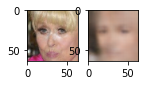

 15%|█▍        | 499/3434 [00:05<00:30, 96.72it/s]

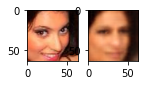

 29%|██▉       | 996/3434 [00:10<00:26, 91.42it/s]

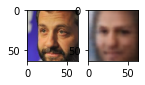

 44%|████▎     | 1500/3434 [00:16<00:20, 95.79it/s]

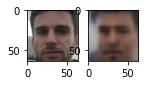

 58%|█████▊    | 2000/3434 [00:21<00:16, 86.20it/s]

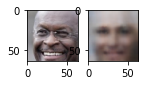

 73%|███████▎  | 2493/3434 [00:27<00:09, 94.77it/s]

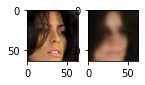

 87%|████████▋ | 2997/3434 [00:32<00:04, 97.22it/s]

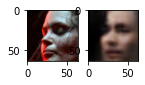

100%|██████████| 3434/3434 [00:37<00:00, 91.81it/s]


In [ ]:
### Training the DB-VAE ###


batch_size = 32
learning_rate = 5e-4
latent_dim = 150


num_epochs =  10 


dbvae = DB_VAE(150)
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:

    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    
  
  
  grads = tape.gradient(loss, dbvae.trainable_variables)
 

  
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss


all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() 


for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  
  
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  
  for j in tqdm(range(loader.get_train_size() // batch_size)):
  
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    
    loss = debiasing_train_step(x, y)
    
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

##Evaluation of DB-VAE on Test Dataset

We test the DB-VAE model on the test dataset, looking at its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics. We will compare the performance of this debiased model against the potentially biased standard CNN from earlier in the lab.

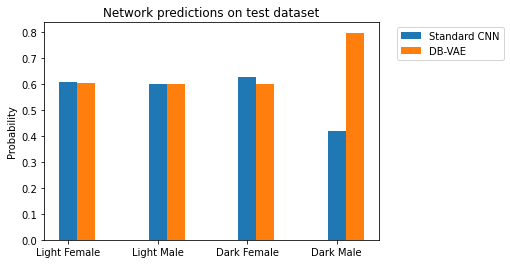

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
